# Introduction

Image registration is a fundamental task in image processing that involves aligning two or more images to a common coordinate system. By doing so, corresponding pixels in the images represent homologous points in the real world, enabling comparison and analysis of the images. One common application of image registration is in medical imaging, where multiple scans or images of the same patient are taken over time, with variations due to differences in time, position, or other factors. Registering these images can reveal subtle changes or patterns that may be indicative of disease progression or treatment efficacy.

Image registration involves finding a spatial transformation that maps points in one image to corresponding points in the other image(s), so that the images can be superimposed on each other. The spatial transformation is typically parameterized by a set of control points, which are used to warp one image to match the other. The quality of the registration is measured by a similarity metric, which quantifies the degree of correspondence between the images.

In recent years, there has been a growing interest in medical image registration due to the availability of advanced imaging modalities, increasing computing power, and the need for more accurate and efficient analysis of medical images. Image registration has become a prerequisite for a wide range of medical image analysis tasks, including segmentation of anatomical structures, computer-aided diagnosis, monitoring of disease progression, surgical intervention, and treatment planning.

Despite the significant amount of research that has focused on developing image registration algorithms, there has been relatively little attention paid to the accessibility, interoperability, and extensibility of these algorithms. Scientific source code is often not published, is difficult to use because it has not been written with other researchers in mind, or lacks proper documentation. This has limited the adoption and use of image registration algorithms, hindering scientific advancement and reproducibility.

To address these challenges, several open-source libraries for medical image registration have been developed, with SimpleElastix being one of the most popular. SimpleElastix is an extension of SimpleITK, an open-source library for medical image analysis, that allows users to configure and run the Elastix registration algorithm entirely in Python, Java, R, Octave, Ruby, Lua, Tcl, and C#. SimpleElastix offers a simple parameter interface, modular architecture, and a range of transforms, metrics, and optimizers, making it easy to use and computationally efficient. It also provides a range of features such as stochastic sampling, multi-threading, and code optimization to make registration run faster without sacrificing robustness.

In this blog post, we will explore the process of image registration using SimpleElastix, focusing on the specific example of registering slices from OCTs of geographic atrophy patients. We will provide a step-by-step guide to implementing this registration process, along with an exploration of other techniques such as optical flow and spatial transformer networks. By the end of this post, you will have a better understanding of the importance of image registration in medical imaging and the tools available to implement it.

# Setup

First, we need to import the appropriate modules.

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
from typing import List
import numpy as np
import seaborn as sns
import os
import cv2
import pandas as pd
from tqdm.notebook import tqdm
from skimage.registration import optical_flow_tvl1, optical_flow_ilk
from skimage.transform import warp
from skimage.color import rgb2gray
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import normalized_root_mse as nrmse

Next, let's write a function to handle retrieving the images. Since we only want to register fundus images to the same eye, we specify which patient and which laterality we want to load in:

In [2]:
def retrieve_images(patient_id = '156518', laterality = 'L', date = None):
    # Set the root directory for the patient data
    root_dir = Path(f'../data/{patient_id}')

    # Get the list of image filenames for the left eye
    image_filenames = [f for f in os.listdir(root_dir) if f'{laterality}.png' in f]
    
    # If we are registering to same visit, only keep files from given date
    if date != None:
        pattern = re.compile(r"\w+_(\d{4}-\d{2}-\d{2})_")
        image_filenames = [file for file in image_filenames if date in file]

    # Read the images into a list
    images = [cv2.imread(str(root_dir / f)) for f in image_filenames]

    # Convert the images to grayscale
    gray_images = [rgb2gray(img) for img in images]

    # Register all images to the first image
    template = gray_images[0]

    # Remove invalid images
    final_images = [x for x in gray_images[1:] if x.shape == template.shape]

    return final_images, template

When evaluating our registration algorithm, our evaluation metric will be some function that computes the distance between the registered images and the template image. We want to be able to track a few of these metrics. Some common ones include:

* _L1 loss_, also known as mean absolute error, measures the average magnitude of the element-wise differences between two images. It is robust to outliers and gives equal weight to all pixels, making it a good choice for image registration.
* _RMSE_, or root mean square error, is the square root of the mean of the squared differences between two images. It gives more weight to larger differences, making it sensitive to outliers. RMSE is commonly used in image registration to measure the overall difference between two images.
* _Normalised cross-correlation_ is a measure of the similarity between two images, taking into account their intensities. It is normalised to ensure that the result is between -1 and 1, where 1 indicates a perfect match. Normalised cross-correlation is often used in image registration to assess the quality of the registration, especially when dealing with images with different intensities.
* _Similarity_ is a measure of the overlap between two images, taking into account both the intensities and spatial information. Common similarity metrics used in image registration include mutual information, normalised mutual information, and the Jensen-Shannon divergence. These metrics provide a measure of the information shared between two images, making them well suited for assessing the quality of image registration.

The following function takes a list of registered images, as well as the template image, and calculates the above metrics for each image:

In [3]:
def evaluate_registration(template_img: np.ndarray, 
                          registered_imgs: List[np.ndarray]) -> (List[float], List[float], List[float]):
    """
    Evaluate the registration quality of multiple registered images with respect to a template image.
    """
    l1_losses = []
    ncc_values = []
    ssim_values = []
    
    for registered_img in registered_imgs:
        # Compute L1 loss between the template and registered images
        l1_loss = np.mean(np.abs(template_img - registered_img))
        l1_losses.append(l1_loss)
        
        # Compute normalized cross-correlation between the template and registered images
        ncc = np.corrcoef(template_img.ravel(), registered_img.ravel())[0,1]
        ncc_values.append(ncc)
        
        # Compute structural similarity index between the template and registered images
        ssim_value = ssim(template_img, registered_img, data_range=registered_img.max() - registered_img.min())
        ssim_values.append(ssim_value)
        
    return l1_losses, ncc_values, ssim_values

Given these losses, it's probably a good idea to have some sort of function that shows us the best and worst registered images, based on the loss. This is somewhat similar to viewing individual examples from a confusion matrix in a classification task. 

In [4]:
def visualise_registration_results(registered_images, original_images, template, loss_values):
    num_images = min(len(registered_images), 3)
    
    # Get the indices of the three images with the highest L1 losses
    top_indices = np.argsort(loss_values)[-num_images:]

    # Get the indices of the three images with the lowest L1 losses
    bottom_indices = np.argsort(loss_values)[:num_images]

    # Create the grid figure
    fig, axes = plt.subplots(num_images, 4, figsize=(20, 15))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    # Loop through the top three images
    for i, idx in enumerate(top_indices):
        # Plot the original image in the first column of the left section
        ax = axes[i][0]
        ax.imshow(original_images[idx], cmap='gray')
        original_l1 = np.mean(np.abs(template - original_images[idx]))
        ax.set_title("Original Image (L1 Loss: {:.2f})".format(original_l1))

        # Plot the registered image in the second column of the left section
        ax = axes[i][1]
        ax.imshow(registered_images[idx], cmap='gray')
        ax.set_title("Registered Image (L1 Loss: {:.2f})".format(loss_values[idx]))

    # Loop through the bottom three images
    for i, idx in enumerate(bottom_indices):
        # Plot the original image in the first column of the right section
        ax = axes[i][2]
        ax.imshow(original_images[idx], cmap='gray')
        original_l1 = np.mean(np.abs(template - original_images[idx]))
        ax.set_title("Original Image (L1 Loss: {:.2f})".format(original_l1))

        # Plot the registered image in the second column of the right section
        ax = axes[i][3]
        ax.imshow(registered_images[idx], cmap='gray')
        ax.set_title("Registered Image (L1 Loss: {:.2f})".format(loss_values[idx]))

    # Show the grid
    plt.show()

It's probably a good idea to write a summary function which will show the aggregate improvement our registration has achieved:

In [5]:
def highlight_worse(val, comparison_column, worse_val, better_val):
    color = better_val if val == worse_val else worse_val
    return 'background-color: {}'.format(color)

def style_df(df_dict):
    df = pd.DataFrame(df_dict)
    for column in df.columns:
        comparison_column = 'original' if column == 'registered' else 'registered'
        worse_val = 'red'
        better_val = 'green'
        if column in ['ncc', 'ssim']:
            worse_val, better_val = better_val, worse_val
        df.style.apply(highlight_worse, axis=1, subset=[column], comparison_column=comparison_column, worse_val=worse_val, better_val=better_val)
    return df

def summarise_registration(original_images, registered_images, template):
    
    # Calculate metrics for original images
    l1_losses, ncc_values, ssim_values = evaluate_registration(template, original_images)
    l1_original, ncc_original, ssim_original = np.mean(l1_losses), np.mean(ncc_values), np.mean(ssim_values)
    
    # Calculate metrics for registered images
    l1_losses, ncc_values, ssim_values = evaluate_registration(template, registered_images)
    l1_registered, ncc_registered, ssim_registered = np.mean(l1_losses), np.mean(ncc_values), np.mean(ssim_values)
    
    # Create dataframe
    df_dict = {'original': {'l1': l1_original, 'ncc': ncc_original, 'ssim': ssim_original}, 
               'registered': {'l1': l1_registered, 'ncc': ncc_registered, 'ssim': ssim_registered}}
    
    return style_df(df_dict)

Finally, we'll write a thin wrapper for any registration algorithm to allow us to easily apply and evaluate it:

In [6]:
class RegistrationAlgorithm:
    
    def __init__(self, registration_function):
        self.registration_function = registration_function
        self.final_images, self.template = retrieve_images()
        self.registered_images = self.apply_registration()
        
    def apply_registration(self):
        # Do the registration process
        registered_images = []
        for i, img in enumerate(tqdm(self.final_images)):
            registered = self.registration_function(self.template, img) 
            registered_images.append(registered)
        return registered_images
    
    def evaluate(template_img, registered_imgs):
        l1_losses = []
        ncc_values = []
        ssim_values = []

        for registered_img in registered_imgs:
            # Compute L1 loss between the template and registered images
            l1_loss = np.mean(np.abs(template_img - registered_img))
            l1_losses.append(l1_loss)

            # Compute normalized cross-correlation between the template and registered images
            ncc = np.corrcoef(template_img.ravel(), registered_img.ravel())[0,1]
            ncc_values.append(ncc)

            # Compute structural similarity index between the template and registered images
            ssim_value = ssim(template_img, registered_img, data_range=registered_img.max() - registered_img.min())
            ssim_values.append(ssim_value)

        return l1_losses, ncc_values, ssim_values

# Exploratory data analysis

Let's get some images and see what we're dealing with.

In [7]:
images, template = retrieve_images()

A good idea is probably to examine which of the images are most different from the template image. We can recycle the functions from above to do this. Let's just calculate the losses between the un-registered images and the template, and then look at the most dissimilar ones (highest losses).

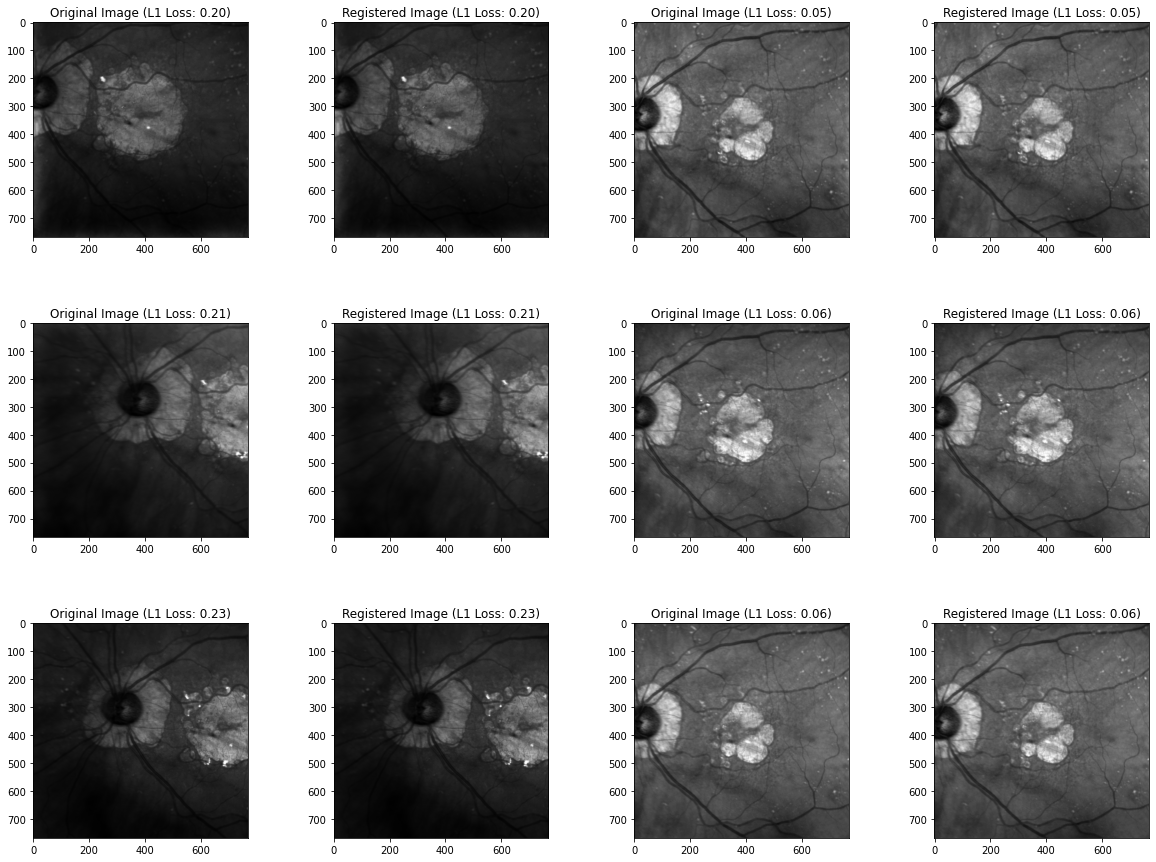

In [8]:
# calculate various distances
l1_losses, ncc_values, ssim_values = evaluate_registration(template, images)

# plot most and least similar images
visualise_registration_results(images, images, template, l1_losses)

For comparison, here is the template image:

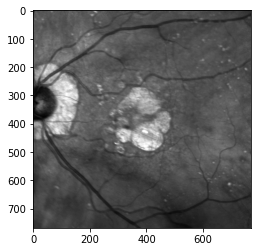

In [9]:
plt.imshow(template, cmap="gray");

## Finding the optimal template image

Obviously, choosing the first fundus image as the _fixed_ or "template" image may not be ideal. What if the first image is poor quality, or rotated, or in general very different from the majority of images to be registered? This will lead to poor results, large affine transformations and high "dead" image areas. Hence, we need some way to pick a template image. There are a few different ideas for how we might do this:

* Calculate the cumulative L2 distance between each image and all other images in the dataset, and pick the one with the lowest result. This represents the image that is "closest" to all the other images.
* Repeat the process from above, but this time create a histogram of cumulative L2 distances. Pick the $k$ best images, take the average, and use this as a template.

Let's begin with the first idea. This function loops over each image, calculating aggregate L2 distance with all other images.

In [10]:
def calculate_total_rmse(images):
    n = len(images)
    sum_rmse = np.zeros(n)
    for i in range(n):
        for j in range(i+1, n):
            rmse = np.sqrt(np.mean((images[i] - images[j])**2))
            sum_rmse[i] += rmse
            sum_rmse[j] += rmse
    return sum_rmse


patient_id = '156518'
laterality = 'L'

# Set the root directory for the patient data
root_dir = Path(f'../data/{patient_id}')

# Get the list of image filenames for the left eye
image_filenames = [f for f in os.listdir(root_dir) if f'{laterality}.png' in f]

# Read the images into a list
images = [cv2.imread(str(root_dir / f)) for f in image_filenames]

# Convert the images to grayscale
gray_images = [rgb2gray(img) for img in images]

# Remove invalid images
final_images = [x for x in gray_images[1:] if x.shape == (768, 768)]

# Calculate the RMSEs
rmses = calculate_total_rmse(final_images)

Let's have a look at the four images with the lowest total RMSEs:

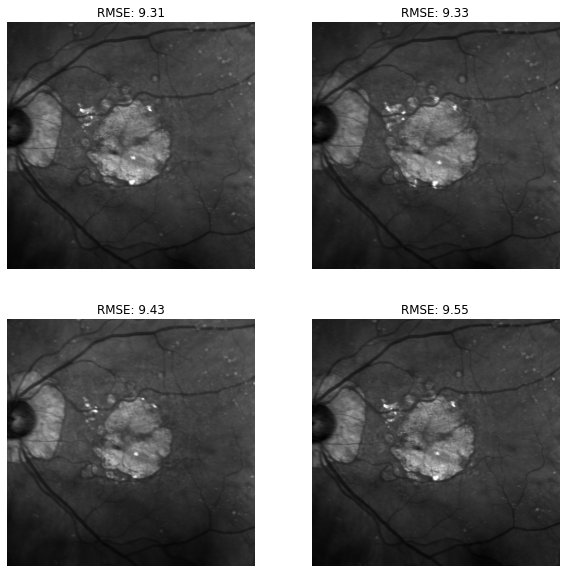

In [11]:
images = final_images
sorted_indices = [i[0] for i in sorted(enumerate(rmses), key=lambda x:x[1])]
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for i in range(4):
    ax[i//2][i%2].imshow(images[sorted_indices[i]], cmap='gray')
    ax[i//2][i%2].set_title("RMSE: {:.2f}".format(rmses[sorted_indices[i]]))
    ax[i//2][i%2].axis("off")
plt.show()

Now let's try the second method. First, let's have a look at the histogram of total RMSEs:

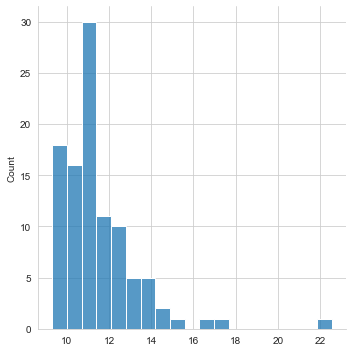

In [12]:
# Plot the histogram
sns.set_style("whitegrid")
sns.displot(rmses, kde=False)
plt.show()
plt.rcdefaults()

We could probably take the best 15 images (all with RMSEs below 10):

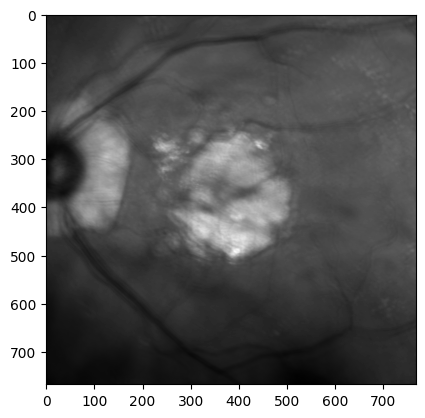

In [13]:
plt.rcdefaults()

def get_best_images(images, rmses, num_images=10):
    sorted_indices = sorted(range(len(rmses)), key=lambda x: rmses[x])
    best_indices = sorted_indices[:num_images]
    return [images[i] for i in best_indices]

best_images = get_best_images(images, rmses)
av_img = np.mean(best_images, axis=0)
plt.imshow(av_img, cmap='gray')
plt.show()

Obviously, the more images we use to take the average of, the blurrier the final image.

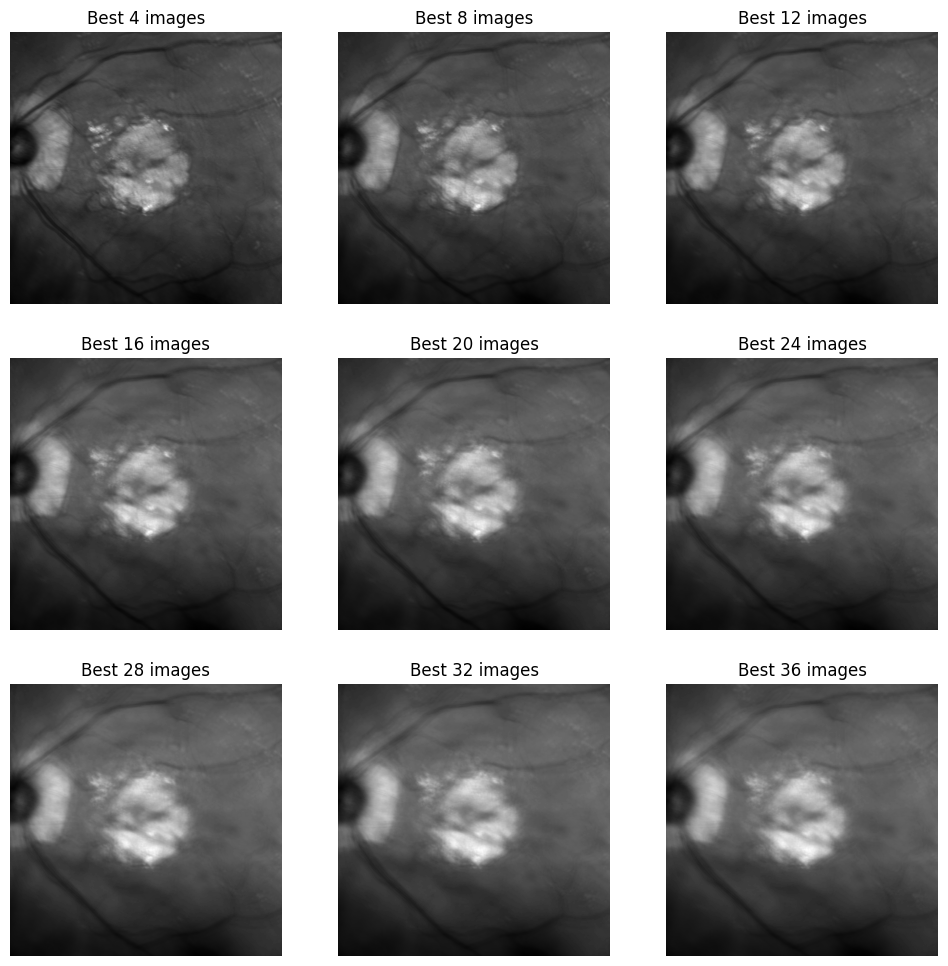

In [14]:
num_images_range = np.linspace(4, 36, 9, dtype=int)
best_images_list = []
for num_images in num_images_range:
    best_images = get_best_images(images, rmses, num_images)
    av_img = np.mean(best_images, axis=0)
    best_images_list.append(av_img)

fig, axs = plt.subplots(3, 3, figsize=(12,12))
for i, av_img in enumerate(best_images_list):
    row, col = i//3, i%3
    axs[row, col].imshow(av_img, cmap='gray')
    axs[row, col].axis('off')
    axs[row, col].set_title(f"Best {num_images_range[i]} images")
plt.show()

# Algorithms

## Rigid

In [36]:
import SimpleITK as sitk
import numpy as np

def rigid(fixed_image, moving_image):
    # Convert the input images to SimpleITK images
    fixed_image = sitk.GetImageFromArray(fixed_image)
    moving_image = sitk.GetImageFromArray(moving_image)

    # Create a rigid registration method and set the initial transform to the identity
    registration_method = sitk.ImageRegistrationMethod()
    initial_transform = sitk.Euler2DTransform()
    initial_transform.SetMatrix(np.eye(2).ravel())
    initial_transform.SetTranslation([0, 0])
    registration_method.SetInitialTransform(initial_transform)

    # Set the number of iterations and the learning rate for the optimization
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100)

    # Use mean squared error as the similarity metric
    registration_method.SetMetricAsMeanSquares()

    # Execute the registration
    final_transform = registration_method.Execute(fixed_image, moving_image)

    # Transform the moving image using the final transform
    registered_image = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelIDValue())

    # Convert the registered image back to a Numpy array
    registered_image = sitk.GetArrayFromImage(registered_image)

    return registered_image

In [37]:
class RegistrationAlgorithm:
    
    def __init__(self, registration_function):
        self.registration_function = registration_function
        self.final_images, self.template = retrieve_images()
        self.registered_images = self.apply_registration()
        
    def apply_registration(self):
        # Do the registration process
        registered_images = []
        for i, img in enumerate(tqdm(self.final_images)):
            registered = self.registration_function(self.template, img) 
            registered_images.append(registered)
        return registered_images
    
    def evaluate(self, template_img, registered_imgs):
        l1_losses = []
        ncc_values = []
        ssim_values = []

        for registered_img in registered_imgs:
            # Compute L1 loss between the template and registered images
            l1_loss = np.mean(np.abs(template_img - registered_img))
            l1_losses.append(l1_loss)

            # Compute normalized cross-correlation between the template and registered images
            ncc = np.corrcoef(template_img.ravel(), registered_img.ravel())[0,1]
            ncc_values.append(ncc)

            # Compute structural similarity index between the template and registered images
            ssim_value = ssim(template_img, registered_img, data_range=registered_img.max() - registered_img.min())
            ssim_values.append(ssim_value)

        return l1_losses, ncc_values, ssim_values

In [38]:
opt = RegistrationAlgorithm(rigid)
l1_losses, ncc_values, ssim_values = opt.evaluate(opt.template, opt.registered_images)
print("L1 losses:", f"{np.mean(l1_losses):.2f}")
print("Normalized cross-correlation values:", f"{np.mean(ncc_values):.2f}")
print("Structural similarity index values:", f"{np.mean(ssim_values):.2f}")

  0%|          | 0/101 [00:00<?, ?it/s]

L1 losses: 0.14
Normalized cross-correlation values: 0.56
Structural similarity index values: 0.55


In [18]:
images, template = retrieve_images()
summarise_registration(images, opt.registered_images, template)

original  registered
l1    0.125039    0.139685
ncc   0.629651    0.559018
ssim  0.575398    0.552533

Our metrics are worse. Let's see what's actually happening:

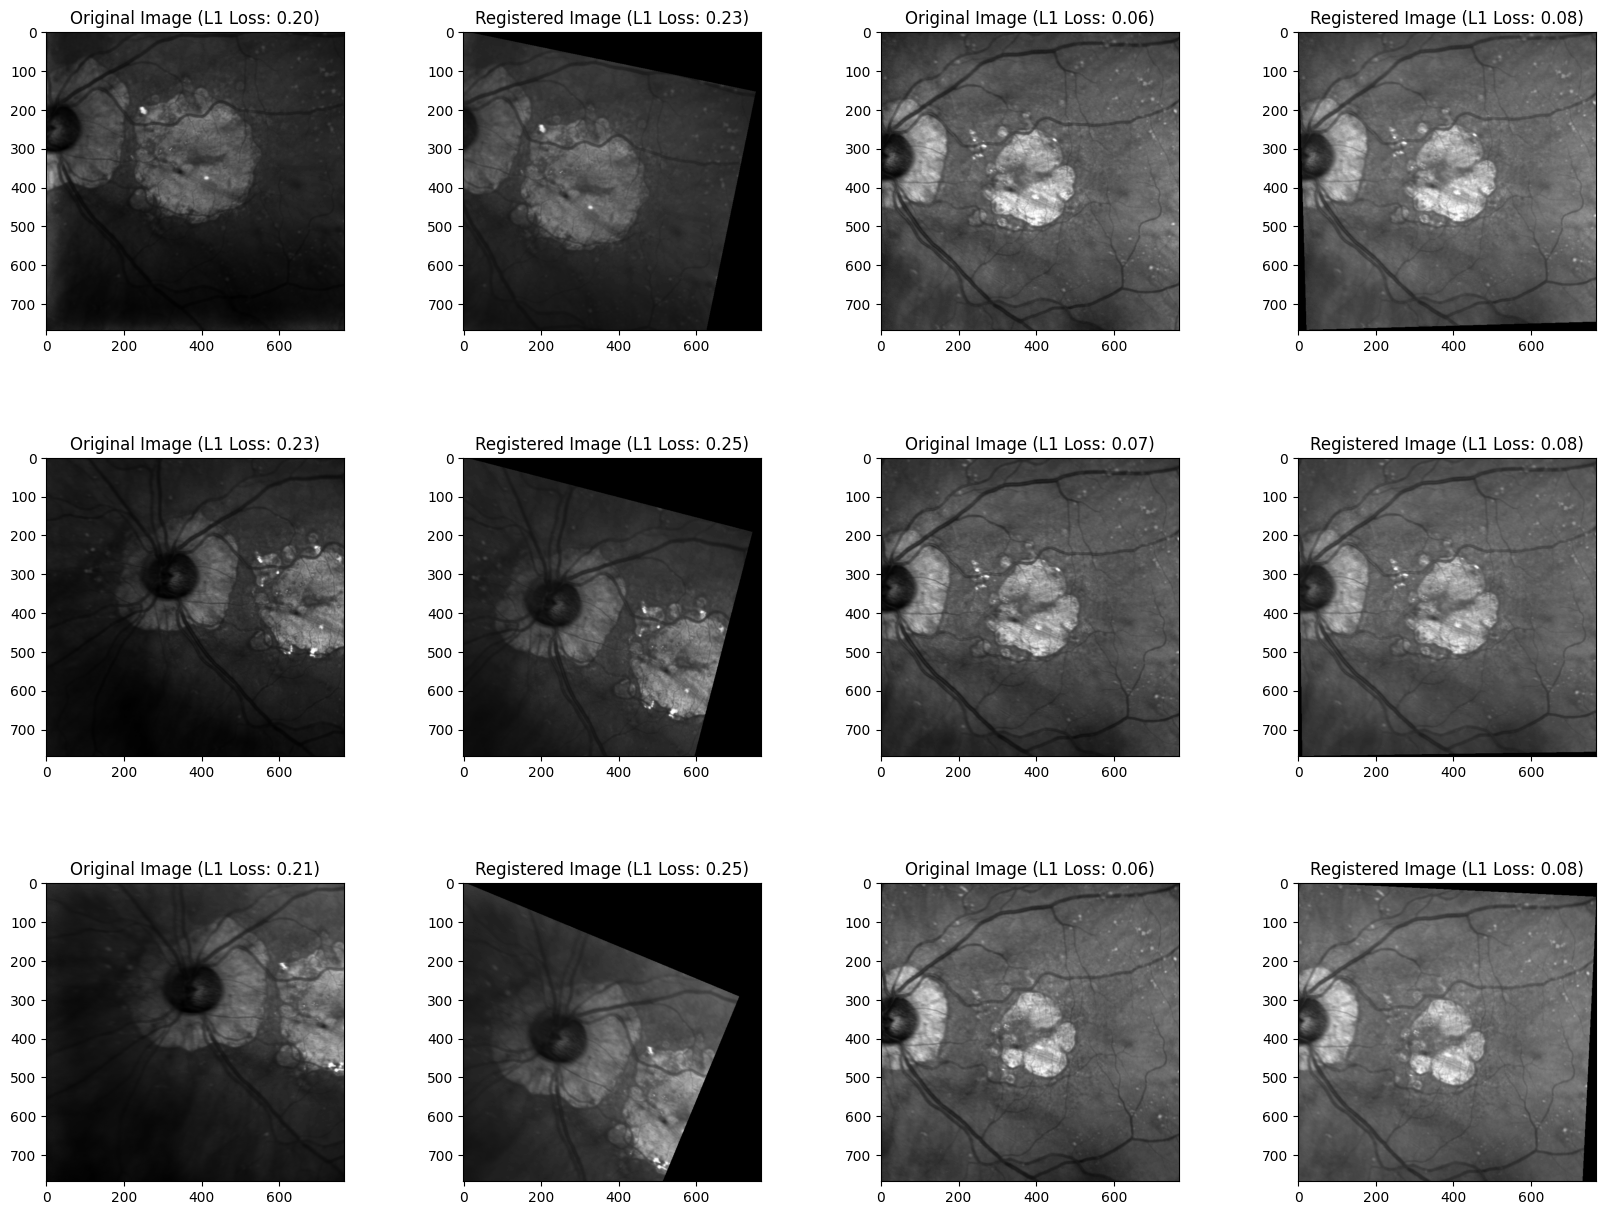

In [19]:
visualise_registration_results(opt.registered_images, images, template, l1_losses)

Interesting. So the metrics are generally worse, but it appears this way because the metrics are comparing large black areas on shifted images. We should probably include the same metrics as above, but exclude completely black pixels from the comparison.

In [81]:
def evaluate_registration(template_img: np.ndarray, registered_imgs: List[np.ndarray]):
    """
    Evaluate the registration quality of multiple registered images with respect to a template image.
    """
    l1_losses = []
    ncc_values = []
    ssim_values = []
    l1_losses_excl_black = []
    ncc_values_excl_black = []
    ssim_values_excl_black = []
    
    for i, registered_img in enumerate(registered_imgs):
        
        # Create mask of non-black pixels in original image
        mask = (registered_img.ravel() != 0.0)
        
        # Compute L1 loss between the template and registered images
        l1_loss = np.mean(np.abs(template_img - registered_img))
        l1_losses.append(l1_loss)
        
        # Compute L1 loss between the template and registered images, excluding black pixels
        l1_loss_excl_black = np.mean(np.abs(template_img.ravel()[mask] - registered_img.ravel()[mask]))
        l1_losses_excl_black.append(l1_loss_excl_black)
        
        # Compute normalized cross-correlation between the template and registered images
        ncc = np.corrcoef(template_img.ravel(), registered_img.ravel())[0,1]
        ncc_values.append(ncc)
        
        # Compute normalized cross-correlation between the template and registered images, excluding black pixels
        ncc_excl_black = np.corrcoef(template_img.ravel()[mask], registered_img.ravel()[mask])[0,1]
        ncc_values_excl_black.append(ncc_excl_black)
        
        # Compute structural similarity index between the template and registered images
        ssim_value = ssim(template_img, registered_img, data_range=registered_img.max() - registered_img.min())
        ssim_values.append(ssim_value)
        
        # Compute structural similarity index between the template and registered images, excluding black pixels
        ssim_value_excl_black = ssim(template_img.ravel()[mask], registered_img.ravel()[mask], 
                                     data_range=registered_img.ravel()[mask].max() - registered_img.ravel()[mask].min())
        ssim_values_excl_black.append(ssim_value_excl_black)
        
    return l1_losses, ncc_values, ssim_values, l1_losses_excl_black, ncc_values_excl_black, ssim_values_excl_black

def summarise_registration(original_images, registered_images, template):
    
    # Calculate metrics for original images
    l1_losses, ncc_values, ssim_values, l1_losses_black, ncc_values_black, ssim_values_black = evaluate_registration(template, original_images)
    l1_original, ncc_original, ssim_original = np.mean(l1_losses), np.mean(ncc_values), np.mean(ssim_values)
    l1_black_original, ncc_black_original, ssim_black_original = np.mean(l1_losses_black), np.mean(ncc_values_black), np.mean(ssim_values_black)
    
    # Calculate metrics for registered images
    l1_losses, ncc_values, ssim_values, l1_losses_black, ncc_values_black, ssim_values_black = evaluate_registration(template, registered_images)
    l1_registered, ncc_registered, ssim_registered = np.mean(l1_losses), np.mean(ncc_values), np.mean(ssim_values)
    l1_black_registered, ncc_black_registered, ssim_black_registered = np.mean(l1_losses_black), np.mean(ncc_values_black), np.mean(ssim_values_black)
    
    # Create dataframe
    df_dict = {'original': {'l1': l1_original, 'ncc': ncc_original, 'ssim': ssim_original,
                            'l1_excl_black': l1_black_original, 'ncc_excl_black': ncc_black_original,
                            'ssim_excl_black': ssim_black_original}, 
               'registered': {'l1': l1_registered, 'ncc': ncc_registered, 'ssim': ssim_registered,
                              'l1_excl_black': l1_black_registered, 'ncc_excl_black': ncc_black_registered,
                              'ssim_excl_black': ssim_black_registered}}
    
    return style_df(df_dict)

In [82]:
images, template = retrieve_images()
summarise_registration(images, opt.registered_images, template)

original  registered
l1               0.125039    0.139685
ncc              0.629651    0.559018
ssim             0.575398    0.552533
l1_excl_black    0.125039    0.123744
ncc_excl_black   0.629651    0.599387
ssim_excl_black  0.670079    0.677921

Not really much better. The only metric where it is definitely better is SSIM excluding black pixels. A theory about why this might be the case is that by excluding black pixels, we are also excluding the retina, which is already very well aligned with the majority of images, and hence "dampens" the metrics for the well-aligned images.

## Optical flow

The optical flow can be defined as a vector field, represented as $(u, v)$, which verifies the equation $image1(x+u, y+v) = image0(x, y)$ for a sequence of consecutive 2D frames $(image0, image1)$. This vector field can then be utilised for image registration through warping.

To visualise the results of the registration, an RGB image is created by assigning the registered image to the red channel, and the target image to both the green and blue channels. If the registration is accurate, the resulting image will appear as a gray-scale image. Conversely, misregistered pixels will appear in color in the constructed RGB image.

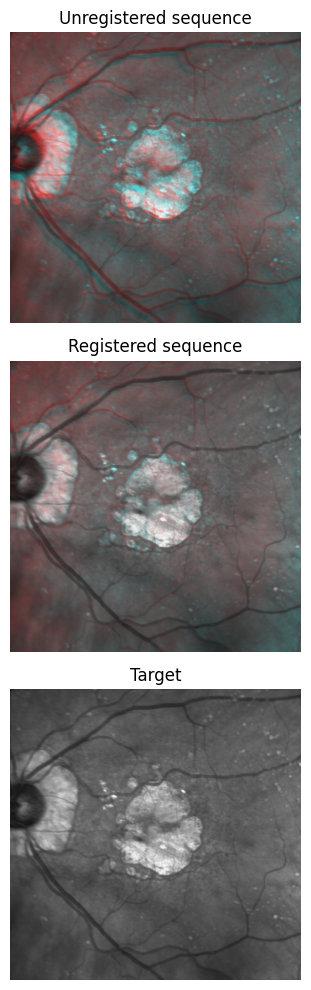

In [83]:
# --- Load the sequence
images, template = retrieve_images()
image0, image1 = images[0], template

# --- Convert the images to gray level: color is not supported.
#image0 = rgb2gray(image0)
#image1 = rgb2gray(image1)

# --- Compute the optical flow
v, u = optical_flow_tvl1(image0, image1)

# --- Use the estimated optical flow for registration

nr, nc = image0.shape

row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc),
                                     indexing='ij')

image1_warp = warp(image1, np.array([row_coords + v, col_coords + u]),
                   mode='edge')

# build an RGB image with the unregistered sequence
seq_im = np.zeros((nr, nc, 3))
seq_im[..., 0] = image1
seq_im[..., 1] = image0
seq_im[..., 2] = image0

# build an RGB image with the registered sequence
reg_im = np.zeros((nr, nc, 3))
reg_im[..., 0] = image1_warp
reg_im[..., 1] = image0
reg_im[..., 2] = image0

# build an RGB image with the registered sequence
target_im = np.zeros((nr, nc, 3))
target_im[..., 0] = image0
target_im[..., 1] = image0
target_im[..., 2] = image0

# --- Show the result

fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(5, 10))

ax0.imshow(seq_im)
ax0.set_title("Unregistered sequence")
ax0.set_axis_off()

ax1.imshow(reg_im)
ax1.set_title("Registered sequence")
ax1.set_axis_off()

ax2.imshow(target_im)
ax2.set_title("Target")
ax2.set_axis_off()

fig.tight_layout()

The estimated vector field $(u, v)$ can also be displayed with a quiver plot.

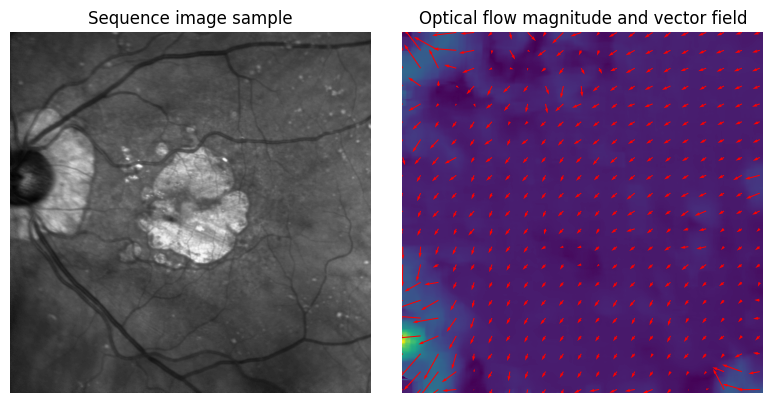

In [84]:
# --- Compute the optical flow
v, u = optical_flow_ilk(image0, image1, radius=15)

# --- Compute flow magnitude
norm = np.sqrt(u ** 2 + v ** 2)

# --- Display
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 4))

# --- Sequence image sample

ax0.imshow(image0, cmap='gray')
ax0.set_title("Sequence image sample")
ax0.set_axis_off()

# --- Quiver plot arguments

nvec = 20  # Number of vectors to be displayed along each image dimension
nl, nc = image0.shape
step = max(nl//nvec, nc//nvec)

y, x = np.mgrid[:nl:step, :nc:step]
u_ = u[::step, ::step]
v_ = v[::step, ::step]

ax1.imshow(norm)
ax1.quiver(x, y, u_, v_, color='r', units='dots',
           angles='xy', scale_units='xy', lw=3)
ax1.set_title("Optical flow magnitude and vector field")
ax1.set_axis_off()
fig.tight_layout()

plt.show()

In [85]:
def optical_flow(template, img):
    # calculate the vector field for optical flow
    v, u = optical_flow_tvl1(template, img)
    # use the estimated optical flow for registration
    nr, nc = template.shape
    row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc),
                                         indexing='ij')
    registered = warp(img, np.array([row_coords + v, col_coords + u]), mode='edge')
    return registered

In [86]:
opt = RegistrationAlgorithm(optical_flow)

  0%|          | 0/101 [00:00<?, ?it/s]

In [88]:
images, template = retrieve_images()
summarise_registration(images, opt.registered_images, template).loc[['l1', 'ncc', 'ssim']]

original  registered
l1    0.125039    0.081696
ncc   0.629651    0.729704
ssim  0.575398    0.634306

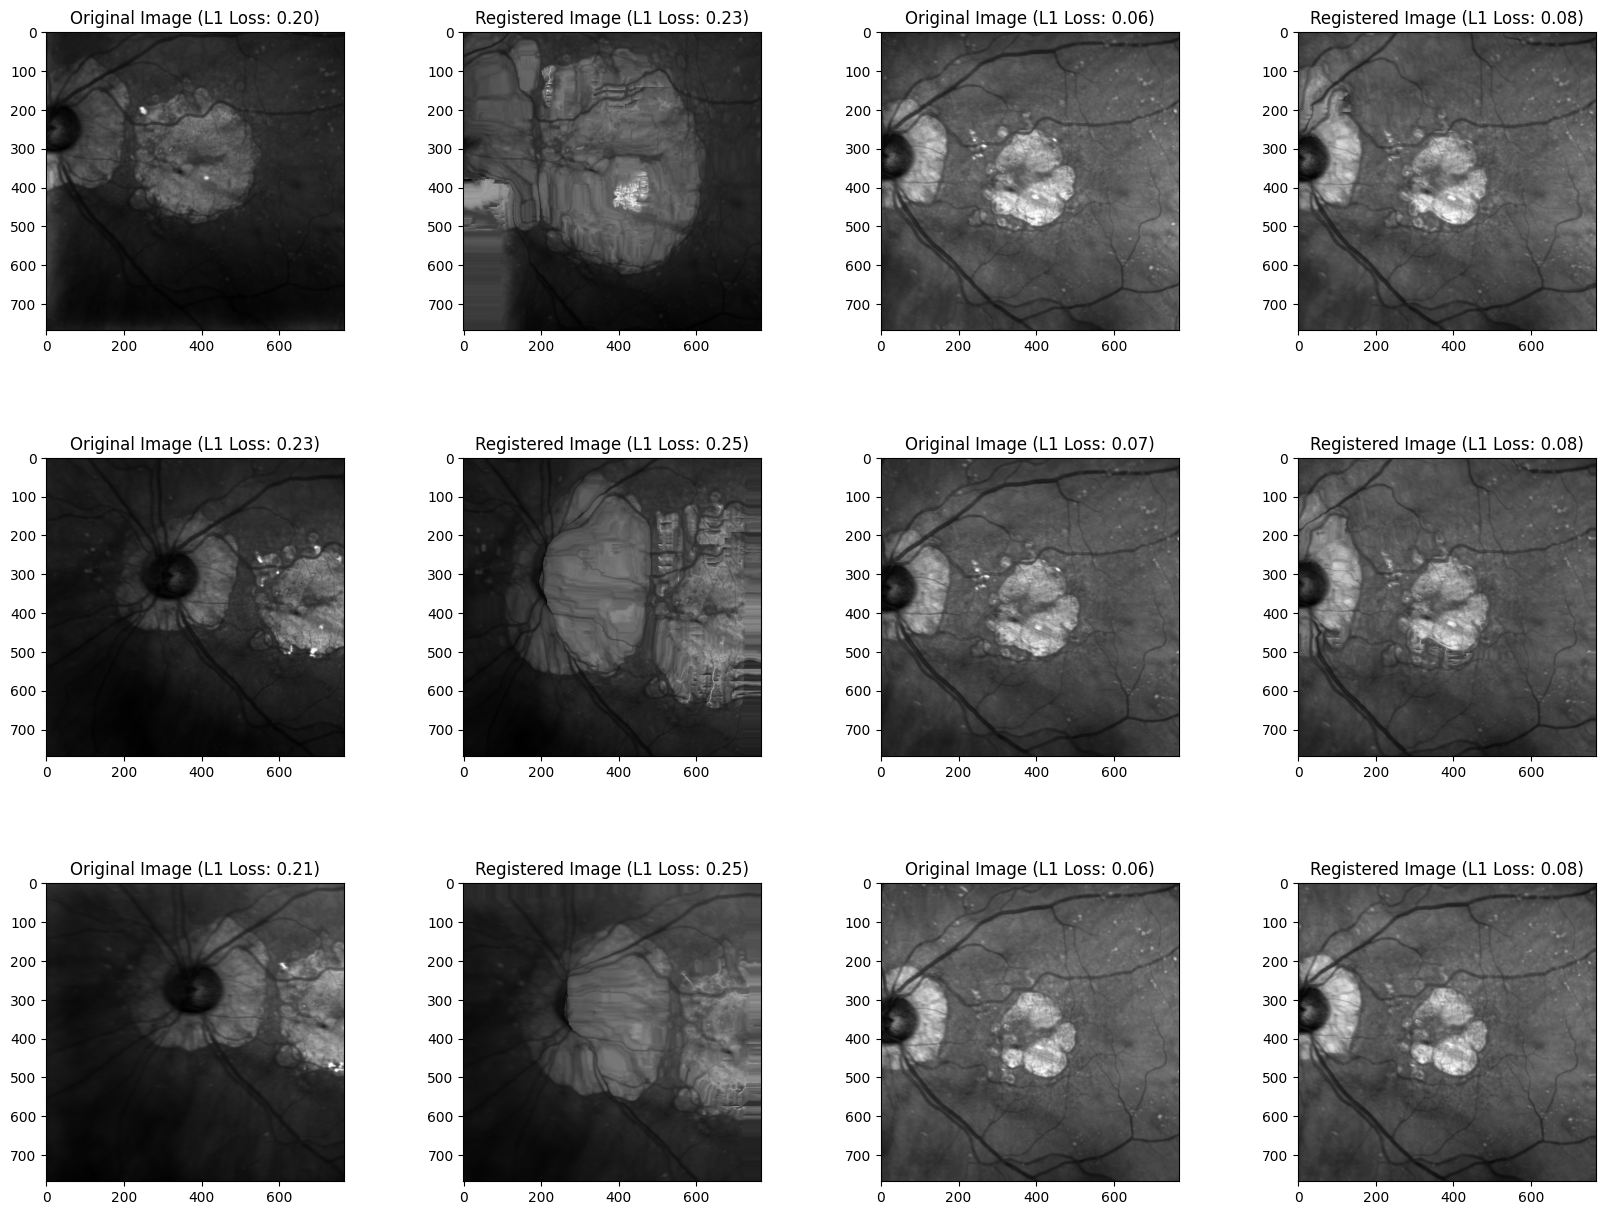

In [89]:
images, template = retrieve_images()
visualise_registration_results(opt.registered_images, images, template, l1_losses)

## SimpleElastix

The main idea is to solve a pairwise optimisation problem by minimising the cost function $C$. The optimisation can be formulated as

$$
\hat{T} = \text{argmin}_T C(T, I_f, I_m)
$$

with cost function defined as 

$$C(T, I_f, I_m) = -S(T, I_f, I_m) + \gamma P(T)$$

where $T$ is the transformation matrix, $S$ is the similarity measurement and $P$ is the penalty term with regulariser parameter $\gamma$. 

SimpleElastix is based on the parametric approach to solve the optimisation problem, where the number of possible transformations are limited by introducing a parametrisation (model) of the transform. The optimisation becomes 

$$\hat{T}_\mu = \text{argmin}_{T_\mu} C(T_\mu, I_f, I_m)$$

$T_\mu$ denotes the parametrisation model and vector $\mu$ contains the values of the transformation parameters. For 2D rigid transformation, the parameter vector $\mu$ contains one rotation angle and the translation in $x$ and $y$ direction.

In [211]:
import SimpleITK as sitk

def simple_elastix(image, template):
    # Convert the input images to SimpleITK images
    moving_image = sitk.GetImageFromArray(image)
    fixed_image = sitk.GetImageFromArray(template)

    # Create the registration method
    registration_method = sitk.DemonsRegistrationFilter()

    # Set the parameters
    registration_method.SetNumberOfIterations(100)
    registration_method.SetStandardDeviations(0.01)

    # Execute the registration
    registered_image = registration_method.Execute(fixed_image, moving_image)

    # Convert the result to a numpy array
    registered_image = sitk.GetArrayFromImage(registered_image)

    # Extract the first component (displacement field) from the registered image
    registered_image = np.mean(registered_image, axis=2)

    return registered_image

And now we preprocess the images as before, getting the template and the images to be registered:

In [212]:
# retrieve images to be registered, and the image to register to
images, template = retrieve_images()

# perform the registration using SimpleElastix
opt = RegistrationAlgorithm(simple_elastix)
l1_losses, ncc_values, ssim_values = opt.evaluate_registration()
print("L1 losses:", f"{np.mean(l1_losses):.2f}")
print("Normalized cross-correlation values:", f"{np.mean(ncc_values):.2f}")
print("Structural similarity index values:", f"{np.mean(ssim_values):.2f}")

  0%|          | 0/2 [00:00<?, ?it/s]

L1 losses: 3.88
Normalized cross-correlation values: 0.02
Structural similarity index values: 0.09


In [ ]:
images, template = retrieve_images()
summarise_registration(images, opt.registered_images, template)

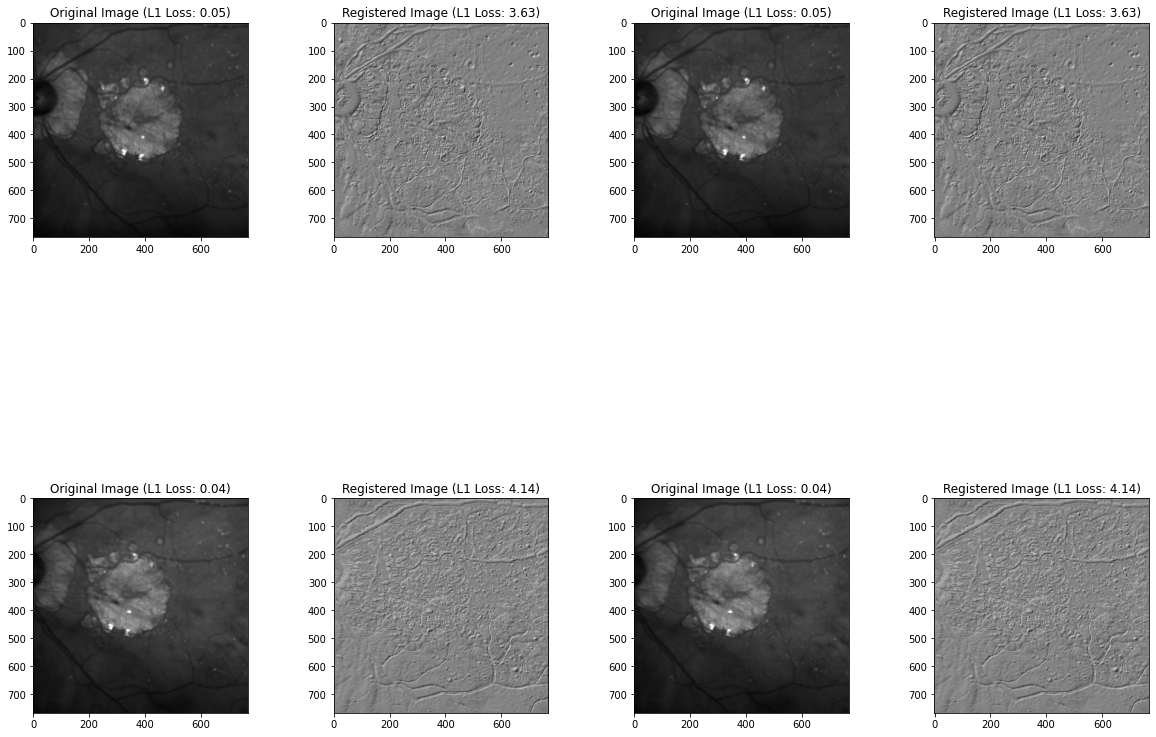

In [213]:
visualise_registration_results(opt.registered_images, images, template, l1_losses)

### Rigid registration

As discussed above, a rigid transformation is capable of aligning objects that are related by translation and rotation. For example, when aligning images of a patient's bones, a rigid transformation is often sufficient to align these structures. It is advantageous to use a simple transformation when possible, as this reduces the number of possible solutions and minimizes the risk of non-rigid local minima that could compromise the accuracy of the registration results. This approach can be seen as a means of incorporating domain expertise into the registration process.

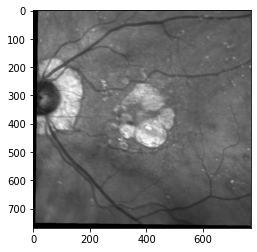

In [7]:
import SimpleITK as sitk
from IPython.display import clear_output
from IPython.display import Image


images, template = retrieve_images()

elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.SetFixedImage(sitk.GetImageFromArray(images[0]))
elastixImageFilter.SetMovingImage(sitk.GetImageFromArray(template))
elastixImageFilter.SetParameterMap(sitk.GetDefaultParameterMap("rigid"))
elastixImageFilter.Execute()
clear_output()
sitk.WriteImage(elastixImageFilter.GetResultImage(), 'test.tif')
# load image with SimpleITK
sitk_image = sitk.ReadImage('test.tif')
# convert to NumPy array
im = sitk.GetArrayFromImage(sitk_image)
plt.imshow(im, cmap='gray');

In [9]:
def simple_elastix_rigid(image, template):
    elastixImageFilter = sitk.ElastixImageFilter()
    elastixImageFilter.SetFixedImage(sitk.GetImageFromArray(image))
    elastixImageFilter.SetMovingImage(sitk.GetImageFromArray(template))
    elastixImageFilter.SetParameterMap(sitk.GetDefaultParameterMap("rigid"))
    elastixImageFilter.Execute()
    clear_output()
    sitk.WriteImage(elastixImageFilter.GetResultImage(), 'reg.tif')
    # load image with SimpleITK
    sitk_image = sitk.ReadImage('reg.tif')
    # convert to NumPy array
    registered_img = sitk.GetArrayFromImage(sitk_image)
    # delete the tif file
    os.remove('reg.tif')
    return registered_img

In [40]:
# retrieve images to be registered, and the image to register to
images, template = retrieve_images()

# perform the registration using SimpleElastix
opt = RegistrationAlgorithm(simple_elastix_rigid)

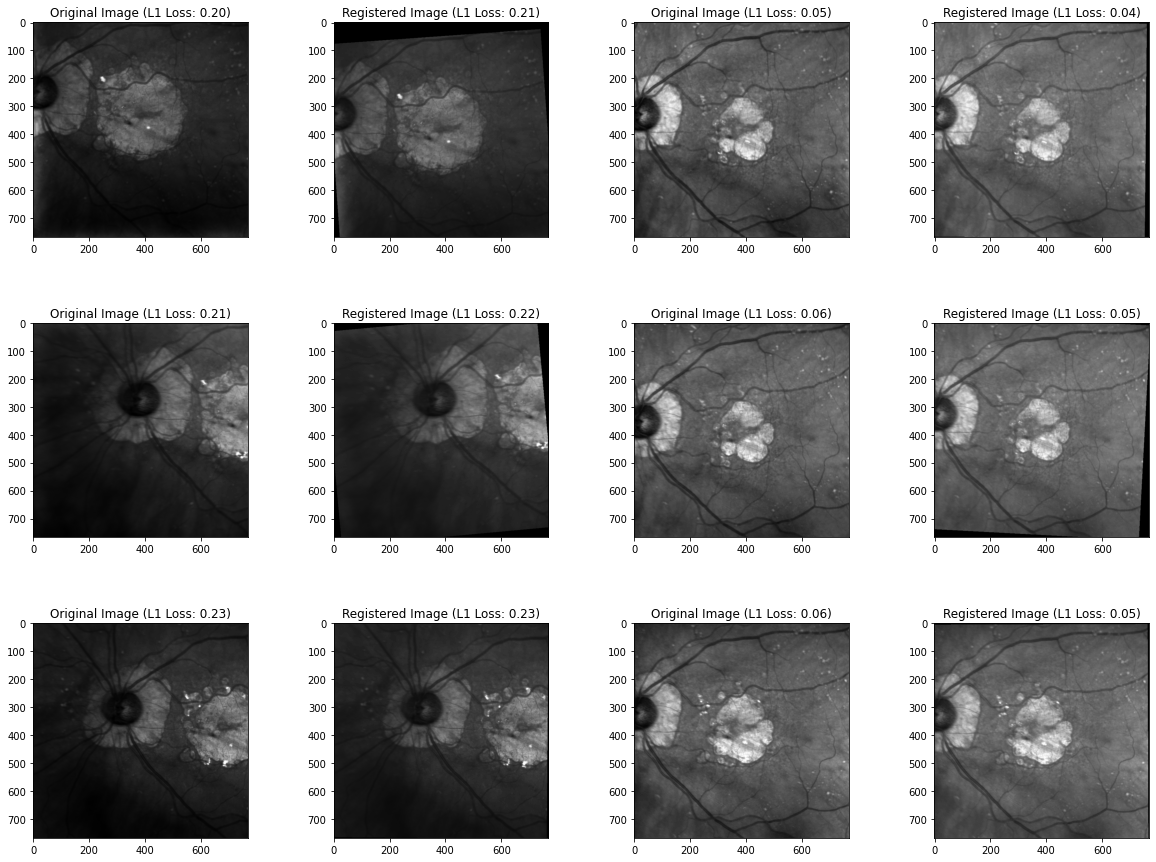

In [41]:
l1_losses, ncc_values, ssim_values = opt.evaluate(opt.template, opt.registered_images)
visualise_registration_results(opt.registered_images, images, template, l1_losses)

In [42]:
images, template = retrieve_images()
summarise_registration(images, opt.registered_images, template)

original  registered
l1    0.125039    0.125193
ncc   0.629651    0.695230
ssim  0.575398    0.684196

Whilst L1 losses are similar, the rigid registration with `SimpleElastix` drastically improves the NCC and structural similarity loss.

## Affine registration

Very similar to rigid registration, the affine transform allows us to shear and scale in addition to rotation and translation. Often, affine registration is used as an initial preprocessing step before non-rigid transformations.

In [44]:
def simple_elastix_affine(image, template):
    elastixImageFilter = sitk.ElastixImageFilter()
    elastixImageFilter.SetFixedImage(sitk.GetImageFromArray(image))
    elastixImageFilter.SetMovingImage(sitk.GetImageFromArray(template))
    elastixImageFilter.SetParameterMap(sitk.GetDefaultParameterMap("affine"))
    elastixImageFilter.Execute()
    clear_output()
    sitk.WriteImage(elastixImageFilter.GetResultImage(), 'reg.tif')
    # load image with SimpleITK
    sitk_image = sitk.ReadImage('reg.tif')
    # convert to NumPy array
    registered_img = sitk.GetArrayFromImage(sitk_image)
    # delete the tif file
    os.remove('reg.tif')
    return registered_img

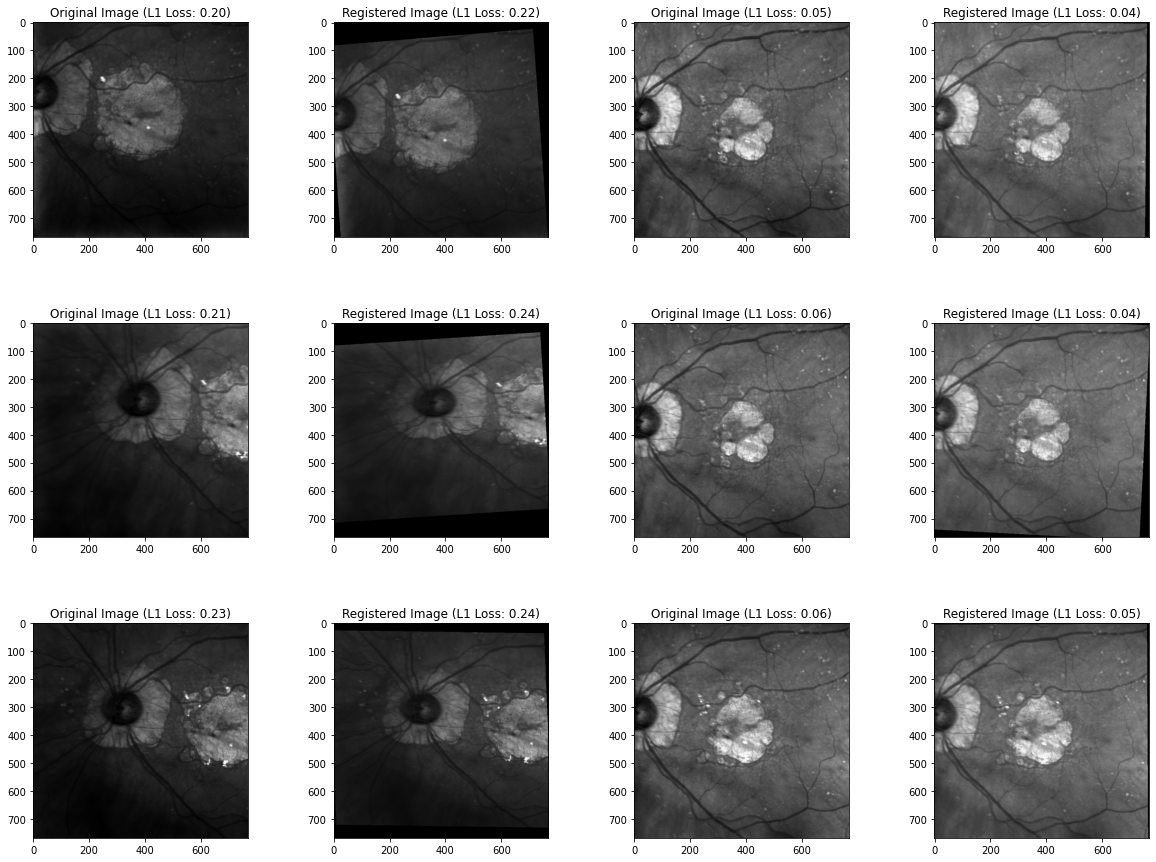

In [46]:
# retrieve images to be registered, and the image to register to
images, template = retrieve_images()

# perform the registration using SimpleElastix
opt = RegistrationAlgorithm(simple_elastix_affine)

l1_losses, ncc_values, ssim_values = opt.evaluate(opt.template, opt.registered_images)
visualise_registration_results(opt.registered_images, images, template, l1_losses)

In [47]:
images, template = retrieve_images()
summarise_registration(images, opt.registered_images, template)

original  registered
l1    0.125039    0.128459
ncc   0.629651    0.698314
ssim  0.575398    0.702732

Slightly better than rigid transformation.

### Non-rigid registration

Non-rigid registration techniques are able to align images that require localised deformations, making them more suitable for accommodating the anatomical, physiological, and pathological variations between patients.

To parameterise a free-form deformation (FFD) field, B-splines are commonly employed. The registration of FFD fields is much more complex than that of simpler transformations. The increased dimensionality of the parameter space makes it challenging to solve the problem, and as such, a multi-resolution approach is recommended. Starting with an affine initialisation can also be helpful to make the registration easier. In SimpleElastix, implementing a multi-resolution approach is straightforward.

The code below runs multi-resolution affine initialisation and then applies a B-spline non-rigid registration transform.

In [49]:
def simple_elastix_nonrigid(image, template):
    
    # Initialise the filter, as well as fixed and moving images
    elastixImageFilter = sitk.ElastixImageFilter()
    elastixImageFilter.SetFixedImage(sitk.GetImageFromArray(image))
    elastixImageFilter.SetMovingImage(sitk.GetImageFromArray(template))
    
    # Setup the initialisation and transforms 
    parameterMapVector = sitk.VectorOfParameterMap()
    parameterMapVector.append(sitk.GetDefaultParameterMap("affine"))
    parameterMapVector.append(sitk.GetDefaultParameterMap("bspline"))
    elastixImageFilter.SetParameterMap(parameterMapVector)
    
    # Execute and save
    elastixImageFilter.Execute()
    clear_output()
    sitk.WriteImage(elastixImageFilter.GetResultImage(), 'reg.tif')
    # load image with SimpleITK
    sitk_image = sitk.ReadImage('reg.tif')
    # convert to NumPy array
    registered_img = sitk.GetArrayFromImage(sitk_image)
    # delete the tif file
    os.remove('reg.tif')
    return registered_img

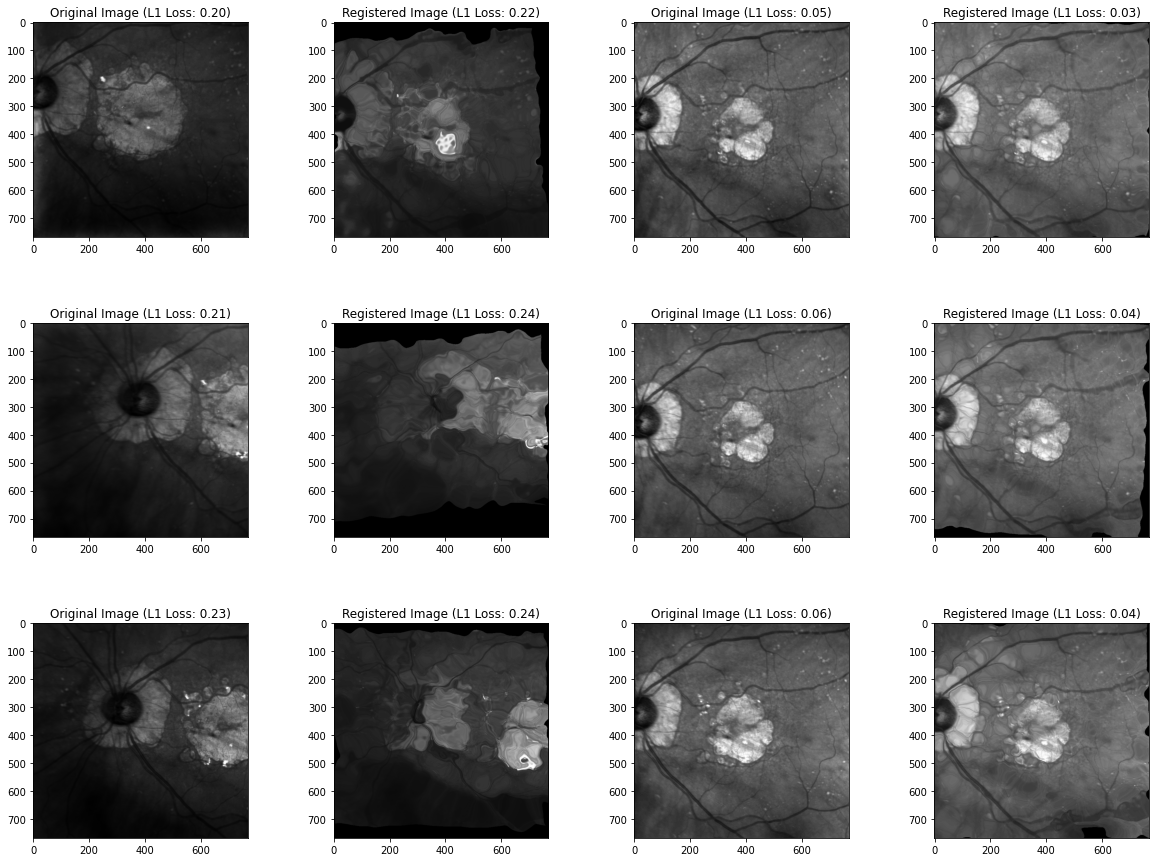

In [51]:
# retrieve images to be registered, and the image to register to
images, template = retrieve_images()

# perform the registration using SimpleElastix
opt = RegistrationAlgorithm(simple_elastix_nonrigid)

l1_losses, ncc_values, ssim_values = opt.evaluate(opt.template, opt.registered_images)
visualise_registration_results(opt.registered_images, images, template, l1_losses)

In [52]:
images, template = retrieve_images()
summarise_registration(images, opt.registered_images, template)

original  registered
l1    0.125039    0.124147
ncc   0.629651    0.789912
ssim  0.575398    0.688098

So SSIM is slightly worse than affine, but NCC is definitely better.

## Groupwise registration

Groupwise registration methods are used in medical imaging to address the uncertainties associated with registering one image to a chosen reference frame. Instead, all images in a population are simultaneously registered to a mean frame of reference that is at the center of the population. This approach uses a 3D or 4D B-spline deformation model and a similarity metric that minimizes intensity variance while ensuring that the average deformation across images is zero. The method can also incorporate temporal smoothness of the deformations and a cyclic transform in the time dimension, which is useful in cases where the anatomical motion has a cyclic nature, such as in cardiac or respiratory motion. By using this method, bias towards a specific reference frame is eliminated, resulting in more accurate and unbiased registration of the images. However, this method is too computationally intensive without parallel processing, and so is not covered here for the sake of efficiency.

## 2D Voxelmorph with Spatial Transformer Network

In [17]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
def voxelmorph_loss_2d(source, target, source_weight=1, target_weight=1, smoothness_weight=0.001):
    def gradient(x):
        d_dx = x[:, :-1, :-1] - x[:, 1:, :-1]
        d_dy = x[:, :-1, :-1] - x[:, :-1, 1:]
        return d_dx, d_dy

    def gradient_penalty(x):
        d_dx, d_dy = gradient(x)
        return (d_dx.abs().mean() + d_dy.abs().mean()) * smoothness_weight
    
    reconstruction_loss = (source - target).abs().mean() * target_weight
    smoothness_penalty = gradient_penalty(target)
    return reconstruction_loss + smoothness_penalty

The Spatial Transformer Network (STN) is a neural network architecture that can learn to spatially transform images in order to improve the performance of downstream tasks. In particular, the STN is capable of learning to automatically crop, rotate, scale, and skew input images in a way that is optimal for the task at hand. This is achieved by learning to estimate a set of affine transformation parameters for each input image, which can be used to warp the image into a new configuration.

In the code below, the STN is implemented as a module within a larger neural network, which consists of several convolutional layers and fully connected layers. The STN consists of two components: a localisation network, and a regressor.

The localisation network is a set of convolutional layers that are used to extract a set of features from the input image. These features are then fed into the regressor, which is a set of fully connected layers that are used to estimate the affine transformation parameters. In the provided code, the regressor consists of two linear layers with ReLU activation functions.

The STN module also includes a `stn` method, which takes an input image as input and applies the learned affine transformation to the image using bilinear interpolation. The `stn` method is called within the forward method of the larger neural network, which is used to make predictions on the transformed input.

Overall, the STN module provides a powerful tool for learning to perform spatial transformations on input images, which can be used to improve the performance of a wide range of image processing and computer vision tasks.

In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 188 * 188, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 188 * 188)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)
        return x


model = Net().to(device)

In [20]:
class FundusDataset(Dataset):
    def __init__(self, image_list, target_image):
        self.image_list = image_list
        self.target_image = target_image

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image = self.image_list[idx]
        image = torch.from_numpy(image).float()
        return image, self.target_image

# Load your list of Numpy arrays of training images
training_images, template = retrieve_images()
template_image = torch.from_numpy(template).float()

# Create the dataset
dataset = FundusDataset(training_images, template_image)

# Create the data loader
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.05)
criterion = voxelmorph_loss_2d #nn.L1Loss() #nn.MSELoss()

def train(epoch):
    model.train()
    batch_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = data.unsqueeze(1)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output.reshape(output.shape[0], 768, 768), target)
        batch_loss += loss.item()
        loss.backward()
        optimizer.step()
    if epoch % 1 == 0:
        avg_loss = batch_loss / len(train_loader)
        print('Train Epoch: {}, Average Loss: {:.6f}'.format(epoch, avg_loss))

for epoch in range(1, 5 + 1):
    train(epoch)

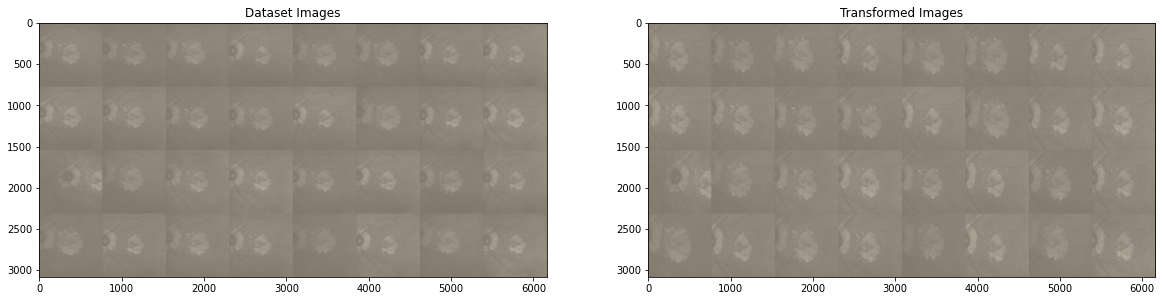

In [31]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(train_loader))[0].to(device)
        data = data.unsqueeze(1)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2, figsize=(20,20))
        axarr[0].imshow(in_grid, cmap='gray')
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid, cmap='gray')
        axarr[1].set_title('Transformed Images')

# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()

# Supersizing registration

## Image augmentation

In [23]:
import numpy as np
from PIL import Image
import cv2
import random
import torchvision.transforms as transforms

def image_augmentation(images, base_index=0, n_aug=5):
    # Convert the NumPy arrays to Pillow Image objects
    items = [Image.fromarray(image).convert("RGBA") for image in images]

    # Define the image transformation pipeline
    transform = transforms.Compose([
        transforms.Resize(460),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2),
                                scale=(0.9, 1.1), shear=0,
                                fillcolor=(128, 128, 128, 255)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Generate the augmented images
    new_items = []
    for i in range(n_aug):
        # Get the base image
        base_item = items[base_index]
        base_image = np.array(base_item)

        # Apply the random transforms to the base image
        transformed_item = transform(base_item)

        # Convert the transformed image to a NumPy array and add it to the list of augmented images
        transformed_image = np.transpose(transformed_item.numpy(), (1, 2, 0))
        transformed_image = cv2.cvtColor(transformed_image, cv2.COLOR_RGB2BGR)
        new_items.append(transformed_image)

    # Convert the augmented data back to NumPy arrays
    new_images = [np.array(image) for image in new_items]

    return new_images



In [24]:
# Assume you have a set of input images stored as NumPy arrays called "images"
images, _ = retrieve_images()

# Generate a set of augmented images based on the first input image
new_images = image_augmentation(images, base_index=0, n_aug=9)

# Display the augmented images in a 3x3 grid
fig, axs = plt.subplots(3, 3, figsize=(6, 6))
for i in range(3):
    for j in range(3):
        axs[i][j].imshow(new_images[i*3+j], cmap='gray')
        axs[i][j].axis('off')
plt.show()

RuntimeError: The size of tensor a (4) must match the size of tensor b (3) at non-singleton dimension 0

## Clustering models with k-nearest neighbours

The below code is an implementation of k-means clustering on a set of images stored as NumPy arrays. The aim of the code is to find the optimal number of clusters that best represent the set of images.

The code begins by converting the list of images to a 2D NumPy array and then reshaping the array to a 2D shape. This is done to create a dataset that can be fed into the k-means clustering algorithm. The k-means algorithm is then run for a range of values of k, where k is the number of clusters to be generated. For each value of k, the algorithm is run, and the within-cluster sum of squares (WCSS) is calculated. The WCSS is a measure of how spread out the data points are within each cluster, and it is used to evaluate the quality of the clustering. The WCSS value is stored in a list, and the loop is repeated for all values of k.

Once the WCSS values are calculated, an elbow plot is generated to visualize the relationship between the number of clusters and the WCSS value. The elbow plot shows a curve that descends and reaches an elbow point where the rate of decrease in WCSS value starts to level off. The optimal number of clusters is chosen as the value at which the curve starts to level off.

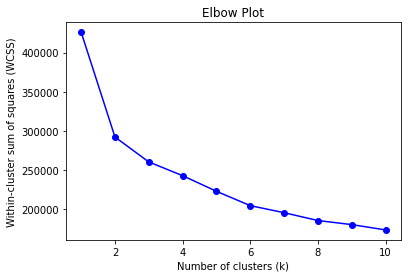

In [10]:
from sklearn.cluster import KMeans

# Assume you have a list of images stored as numpy arrays in a variable called "images"
images, template = retrieve_images()

# Convert the list of images to a 2D numpy array
data = np.array(images)
n_samples, height, width = data.shape
data = data.reshape(n_samples, height * width)

# Set up an empty list to hold the within-cluster sum of squares (WCSS) values for each value of k
wcss_values = []

# Set up a range of values for k
k_values = range(1, 11)

# Loop over the values of k and fit a k-means model for each value
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(data)
    
    # Calculate the within-cluster sum of squares (WCSS)
    wcss = kmeans.inertia_
    wcss_values.append(wcss)
    
# Plot the WCSS values against the number of clusters
fig, ax = plt.subplots()
ax.plot(k_values, wcss_values, 'bo-')
ax.set_xlabel('Number of clusters (k)')
ax.set_ylabel('Within-cluster sum of squares (WCSS)')
ax.set_title('Elbow Plot')
plt.show()

From this plot, an optimal number of clusters is probably three. Let's use this to group our images:

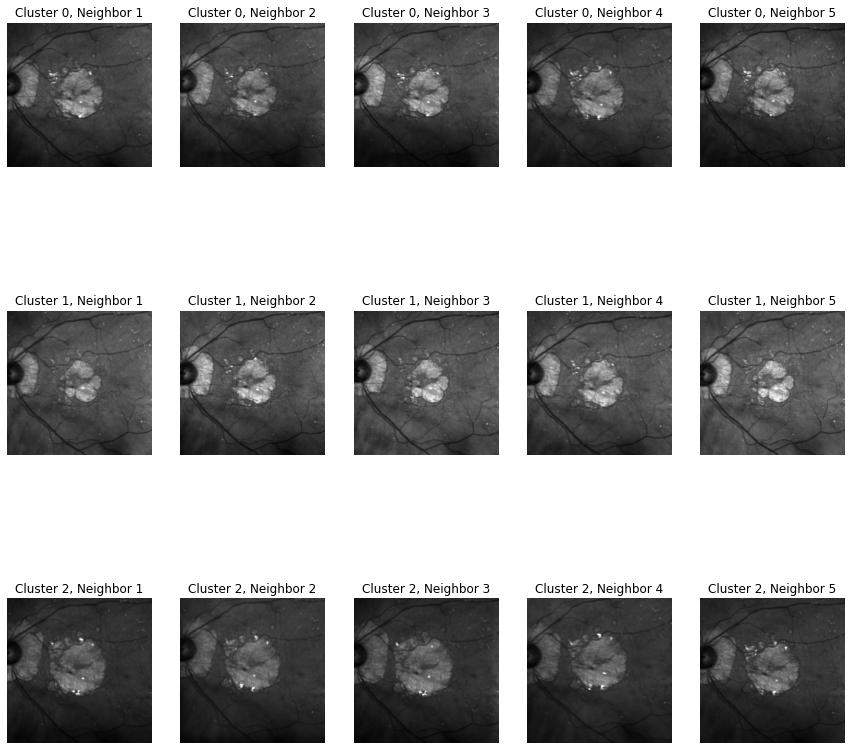

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

# Assume you have a list of images stored as NumPy arrays in a variable called "images"
images, template = retrieve_images()

# First, flatten each image into a 1D array
image_vectors = np.array([image.flatten() for image in images])

# Use k-means to cluster the image vectors
kmeans = KMeans(n_clusters=3, random_state=0).fit(image_vectors)
cluster_labels = kmeans.labels_

# Use k-nearest neighbors to find the nearest images to each centroid
n_neighbors = 5
nn = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(image_vectors)
distances, indices = nn.kneighbors(kmeans.cluster_centers_)

# Plot the nearest images to each centroid
fig, axs = plt.subplots(kmeans.n_clusters, n_neighbors, figsize=(15, 15))
for i in range(kmeans.n_clusters):
    for j in range(n_neighbors):
        axs[i][j].imshow(images[indices[i][j]], cmap='gray')
        axs[i][j].axis('off')
        axs[i][j].set_title(f"Cluster {i}, Neighbor {j+1}")
plt.show()

# Store the cluster labels and image labels in a dictionary
labels_dict = {}
for i in range(len(images)):
    labels_dict[i] = {"cluster_label": cluster_labels[i]}

This looks good. Let's create a new list for each cluster:

In [11]:
# Assume you have a list of images stored as NumPy arrays in a variable called "images"
images, template = retrieve_images()

# First, flatten each image into a 1D array
image_vectors = np.array([image.flatten() for image in images])

# Use k-means to cluster the image vectors
kmeans = KMeans(n_clusters=3, random_state=0).fit(image_vectors)
cluster_labels = kmeans.labels_

# Use k-nearest neighbors to find the nearest images to each centroid
n_neighbors = 5
nn = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(image_vectors)
distances, indices = nn.kneighbors(kmeans.cluster_centers_)

# Store the images in each cluster
cluster_0_images = []
cluster_1_images = []
cluster_2_images = []

for i, cluster_label in enumerate(cluster_labels):
    if cluster_label == 0:
        cluster_0_images.append(images[i])
    elif cluster_label == 1:
        cluster_1_images.append(images[i])
    else:
        cluster_2_images.append(images[i])

# Print the number of images in each cluster
print(f"Number of images in cluster 0: {len(cluster_0_images)}")
print(f"Number of images in cluster 1: {len(cluster_1_images)}")
print(f"Number of images in cluster 2: {len(cluster_2_images)}")

Number of images in cluster 0: 38
Number of images in cluster 1: 31
Number of images in cluster 2: 32


In [24]:
trained_models = {}

for i, cluster_images in enumerate([cluster_0_images, cluster_1_images, cluster_2_images]):
    # load the spatial transformer network
    model = Net().to(device)

    template_image = torch.from_numpy(template).float()

    # Create the dataset
    dataset = FundusDataset(cluster_images, template_image)

    # Create the data loader
    train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

    optimizer = optim.SGD(model.parameters(), lr=0.05)
    criterion = voxelmorph_loss_2d
    
    print(f"TRAINING CLUSTER {i}")
    print("-"*50)

    for epoch in range(1, 5 + 1):
        train(epoch)
        
    trained_models[f"cluster_{i}_model"] = model
    print(" ")

TRAINING CLUSTER 0
--------------------------------------------------
Train Epoch: 1, Average Loss: 0.122363
Train Epoch: 2, Average Loss: 0.120482
Train Epoch: 3, Average Loss: 0.117854
Train Epoch: 4, Average Loss: 0.112581
Train Epoch: 5, Average Loss: 0.119771
 
TRAINING CLUSTER 1
--------------------------------------------------
Train Epoch: 1, Average Loss: 0.079963
Train Epoch: 2, Average Loss: 0.080274
Train Epoch: 3, Average Loss: 0.077222
Train Epoch: 4, Average Loss: 0.076657
Train Epoch: 5, Average Loss: 0.077101
 
TRAINING CLUSTER 2
--------------------------------------------------
Train Epoch: 1, Average Loss: 0.172036
Train Epoch: 2, Average Loss: 0.171105
Train Epoch: 3, Average Loss: 0.170653
Train Epoch: 4, Average Loss: 0.170199
Train Epoch: 5, Average Loss: 0.169759
 
